Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [314]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
import networkx as nx
from icecream import ic
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from itertools import accumulate

#logging.basicConfig(level=logging.DEBUG)

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [315]:
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])
CITIES.head(10)

,name,lat,lon
0,Ancona,43.60,13.50
1,Andria,41.23,16.29
2,Bari,41.12,16.87
3,Bergamo,45.70,9.67
4,Bologna,44.50,11.34
5,Bolzano,46.50,11.35
6,Brescia,45.55,10.22
7,Cagliari,39.22,9.10
8,Catania,37.50,15.08
9,Ferrara,44.84,11.61


In [316]:
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

In [317]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## First Greedy Algorithm

Professor's solution, start from the first city and go to the nearest one, iterate until we visit all the cities. Then we close the cycle by returning to the first city.

In [318]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True
tsp = list()
tsp.append(int(city))
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    #logging.debug(f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)")
    visited[closest] = True
    city = closest
    tsp.append(int(city))
#logging.debug(f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)")
tsp.append(tsp[0])
logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")

INFO:root:result: Found a path of 46 steps, total length 4436.03km


## Second Greedy Algorithm

Professor's solution,

In [319]:
def cyclic(edges):
    G = nx.Graps()
    edges = [list(e) for e, _ in edges]
    G.add_edge_from(edges)
    try:
        nx.find_cycle(G)
        return True
    except:
        return False

In [320]:
segments = [({c1, c2}, float(DIST_MATRIX[c1, c2])) for c1, c2 in combinations(range(len(CITIES)), 2)] #[({c1, c2}, len)]
visited = set()
edges = set()

shortest = next(_ for _ in sorted(segments, key=lambda e: e[1]))
visited |= shortest[0]
#edges |= {tuple(shortest[0])}
#segments = [s for s in segments if not cyclic(edges | {tuple(s[0])})]


## HC

This solutions is not good both in terms of number of steps and cost of the solution, using insert_mutation improves performance slightly compared to using swap_mutation

In [321]:
def swap_mutation(tsp: list):
    new_tsp = tsp.copy()
    pos1 = np.random.randint(0, len(CITIES))
    pos2 = np.random.randint(0, len(CITIES))
    while pos2 == pos1:
        pos2 = np.random.randint(0, len(CITIES))
    new_tsp[pos1] = tsp[pos2]
    new_tsp[pos2] = tsp[pos1]
    return new_tsp

def insert_mutation(tsp: list):
    new_tsp = tsp.copy()
    pos1 = np.random.randint(0, len(CITIES))
    pos2 = np.random.randint(0, len(CITIES))
    while pos2 == pos1:
        pos2 = np.random.randint(0, len(CITIES))
    if pos1 > pos2:
        temp = pos1
        pos1 = pos2
        pos2 = temp
    x = pos2
    while pos1 != pos2:
        pos1 += 1
        new_tsp[pos1] = tsp[x]
        x = pos1
    return new_tsp

def fitness(tsp: list):
    f_tsp = tsp.copy()
    f_tsp.append(tsp[0])
    return -float(tsp_cost(f_tsp))

  0%|          | 0/5000 [00:00<?, ?it/s]

ic| tsp_cost(tsp): np.float64(5128.25135765426)


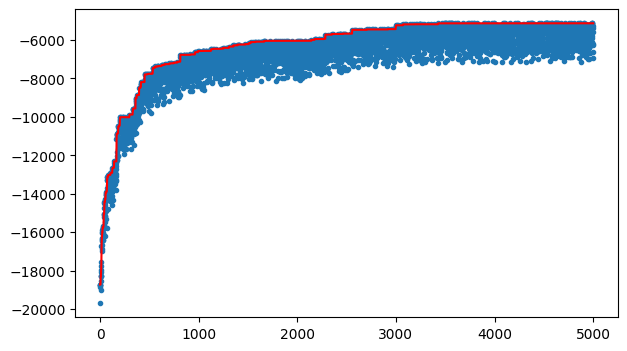

In [322]:
#generate a solution that does not return to the initial city
tsp = list()
for i in range(0, len(CITIES)):
    tsp.append(int(i))
#HC
f_tsp = fitness(tsp)
history = [fitness(tsp)]
for steps in tqdm(range(5000)):
    new_tsp = insert_mutation(tsp)
    f = fitness(new_tsp)
    history.append(f)
    if f > f_tsp:
        tsp = new_tsp
        f_tsp = fitness(tsp)
tsp.append(tsp[0])
ic(tsp_cost(tsp))
plt.figure(figsize=(7, 4))
plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
_ = plt.scatter(range(len(history)), history, marker=".")

## Simulated Annealing

ic| temp: 9.904779116688619e-06
ic| steps: 1713, tsp_cost(tsp): np.float64(6273.610839784718)


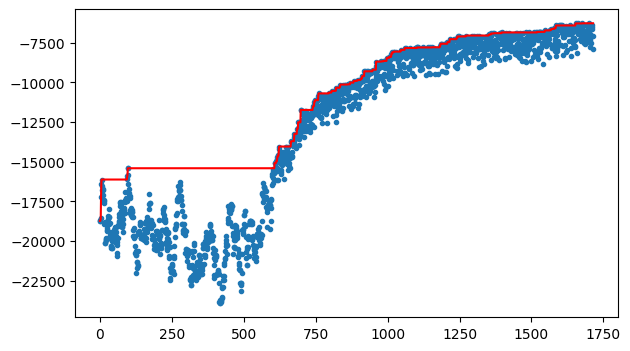

In [323]:
temp=300
cooling_rate=0.99
#generate a solution that does not return to the initial city
tsp = list()
for i in range(0, len(CITIES)):
    tsp.append(int(i))
f_tsp = fitness(tsp)
history = [fitness(tsp)]
for steps in range(2000):
    new_tsp = insert_mutation(tsp)
    f = fitness(new_tsp)
    history.append(f)
    delta_fitness = f - f_tsp
    # Acceptance criterion: accept if the new solution has better fitness, or probabilistically if worse
    if delta_fitness > 0 or np.random.randint(0, 1) < np.exp(delta_fitness / temp):
        tsp = new_tsp
        f_tsp = f
    temp *= cooling_rate
    if temp < 1e-5:
        ic(temp)
        break
tsp.append(tsp[0])
ic(steps, tsp_cost(tsp))
plt.figure(figsize=(7, 4))
plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
_ = plt.scatter(range(len(history)), history, marker=".")


### sources
- prof example
- past exercises
- slides